# Обучение базовой модели логистической регрессии

In [0]:
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
!pip install category_encoders
import category_encoders

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
os.chdir('/content/drive/Shared drives/Кредитные риски')

In [0]:
from CreditRisks.metrics_library.Metrics import *
from CreditRisks.metrics_library.rosstat_utils import *

In [0]:
DIR_OUT='ReadyModels/SGD_final_5/'

## Считывание данных

In [0]:
#df = pd.read_csv('Датасеты/revision_003/companies_ready_train.csv', dtype=RESULT_DTYPES)
df = pd.read_pickle('Датасеты/revision_005/companies_ready_float_train.pkl')
y_train = df['target']
X_train = df.drop(columns=['inn', 'year_-1', 'year_0', 'target'])
df.head()

,inn,year_-1,year_0,target,region,year_-1_okopf,year_-1_okfs,year_-1_okved,year_-1_type,year_-1_11104,year_-1_11204,year_-1_11304,year_-1_11404,year_-1_11504,year_-1_11604,year_-1_11704,year_-1_11804,year_-1_11904,year_-1_11004,year_-1_12104,year_-1_12204,year_-1_12304,year_-1_12404,year_-1_12504,year_-1_12604,year_-1_12004,year_-1_16004,year_-1_13104,year_-1_13204,year_-1_13404,year_-1_13504,year_-1_13604,year_-1_13704,year_-1_13004,year_-1_14104,year_-1_14204,year_-1_14304,year_-1_14504,year_-1_14004,year_-1_15104,...,year_0_15009,year_0_15109,year_0_15209,year_0_15309,year_0_15409,year_0_15509,year_0_16009,year_0_17009,year_0_21009,year_0_21109,year_0_21209,year_0_22009,year_0_22109,year_0_22209,year_0_23009,year_0_23109,year_0_23209,year_0_23309,year_0_23409,year_0_23509,year_0_24009,year_0_24109,year_0_24219,year_0_24309,year_0_24509,year_0_24609,year_0_25009,year_0_25109,year_0_25209,year_0_32009,year_0_33009,year_0_33109,year_0_33149,year_0_33159,year_0_33169,year_0_33209,year_0_33249,year_0_33259,year_0_33269,year_0_36009
0,101000021,2015,2016,0,1,12300,16,52.31,2,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,10.0,780.0,0.0,0.0,0.0,0.0,0.0,780.0,790.0,10.0,0.0,0.0,0.0,0.0,138.0,148.0,0.0,0.0,0.0,0.0,0.0,0.0,...,675.0,0.0,0.0,0.0,0.0,675.0,830.0,830.0,1090.0,5450.0,4360.0,180.0,910.0,0.0,180.0,0.0,0.0,0.0,0.0,0.0,145.0,35.0,0.0,0.0,0.0,0.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,101000078,2015,2016,0,1,12300,16,52.31,2,0.0,0.0,0.0,0.0,543.0,0.0,0.0,0.0,0.0,543.0,1294.0,2.0,7418.0,0.0,394.0,0.0,9108.0,9651.0,10.0,0.0,0.0,5.0,0.0,7120.0,7135.0,2515.0,0.0,0.0,0.0,2515.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,10928.0,10928.0,2269.0,22903.0,20634.0,2269.0,0.0,0.0,2269.0,0.0,0.0,0.0,0.0,0.0,2212.0,57.0,0.0,0.0,0.0,57.0,2212.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,101000511,2015,2016,1,1,12247,16,01.21,2,0.0,0.0,0.0,0.0,5185.0,0.0,6.0,0.0,0.0,5191.0,17619.0,0.0,7198.0,0.0,19.0,0.0,24836.0,30027.0,9660.0,0.0,2387.0,25000.0,0.0,-70162.0,-33115.0,31303.0,0.0,0.0,0.0,31303.0,0.0,...,764.0,0.0,764.0,0.0,0.0,0.0,6110.0,6110.0,14922.0,23001.0,8079.0,14922.0,0.0,0.0,-9768.0,0.0,0.0,0.0,4885.0,29575.0,-9768.0,0.0,0.0,0.0,0.0,0.0,-9768.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,101000737,2012,2013,1,1,65,16,52.12,1,0.0,0.0,0.0,0.0,185.0,0.0,0.0,0.0,0.0,0.0,109.0,0.0,466.0,0.0,24.0,0.0,0.0,784.0,0.0,0.0,0.0,0.0,0.0,0.0,766.0,0.0,0.0,0.0,0.0,0.0,0.0,...,56.0,0.0,56.0,0.0,0.0,0.0,884.0,884.0,145.0,2278.0,2133.0,69.0,76.0,0.0,69.0,0.0,0.0,0.0,0.0,0.0,61.0,8.0,0.0,0.0,0.0,8.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,101000776,2015,2016,0,1,12247,16,15.51.4,2,39.0,0.0,0.0,0.0,210788.0,0.0,3.0,1675.0,10382.0,222887.0,70785.0,887.0,137362.0,0.0,10257.0,7.0,219298.0,442185.0,15.0,0.0,4222.0,4118.0,0.0,243317.0,251672.0,24126.0,9920.0,0.0,0.0,34046.0,65105.0,...,90232.0,15000.0,66414.0,0.0,8818.0,0.0,401807.0,401807.0,417099.0,1570459.0,1153360.0,221214.0,136188.0,59697.0,94737.0,0.0,1019.0,11014.0,110121.0,226603.0,68188.0,28576.0,7602.0,-1618.0,409.0,0.0,68188.0,0.0,0.0,15.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,269860.0


In [0]:
#df1 = pd.read_csv('Датасеты/revision_005/companies_ready_test.csv', dtype=RESULT_DTYPES)
df1 = pd.read_pickle('Датасеты/revision_005/companies_ready_float_test.pkl')
y_test = df1['target']
X_test = df1.drop(columns=['inn', 'year_-1', 'year_0', 'target'])
df1.head()

,inn,year_-1,year_0,target,region,year_-1_okopf,year_-1_okfs,year_-1_okved,year_-1_type,year_-1_11104,year_-1_11204,year_-1_11304,year_-1_11404,year_-1_11504,year_-1_11604,year_-1_11704,year_-1_11804,year_-1_11904,year_-1_11004,year_-1_12104,year_-1_12204,year_-1_12304,year_-1_12404,year_-1_12504,year_-1_12604,year_-1_12004,year_-1_16004,year_-1_13104,year_-1_13204,year_-1_13404,year_-1_13504,year_-1_13604,year_-1_13704,year_-1_13004,year_-1_14104,year_-1_14204,year_-1_14304,year_-1_14504,year_-1_14004,year_-1_15104,...,year_0_15009,year_0_15109,year_0_15209,year_0_15309,year_0_15409,year_0_15509,year_0_16009,year_0_17009,year_0_21009,year_0_21109,year_0_21209,year_0_22009,year_0_22109,year_0_22209,year_0_23009,year_0_23109,year_0_23209,year_0_23309,year_0_23409,year_0_23509,year_0_24009,year_0_24109,year_0_24219,year_0_24309,year_0_24509,year_0_24609,year_0_25009,year_0_25109,year_0_25209,year_0_32009,year_0_33009,year_0_33109,year_0_33149,year_0_33159,year_0_33169,year_0_33209,year_0_33249,year_0_33259,year_0_33269,year_0_36009
0,101000021,2016,2017,0,1,12300,16,47.73,2,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,10.0,820.0,0.0,0.0,0.0,0.0,0.0,820.0,830.0,10.0,0.0,0.0,0.0,0.0,145.0,155.0,0.0,0.0,0.0,0.0,0.0,0.0,...,696.0,0.0,0.0,0.0,0.0,696.0,860.0,860.0,1124.0,5620.0,4496.0,189.0,935.0,0.0,189.0,0.0,0.0,0.0,0.0,0.0,154.0,35.0,0.0,0.0,0.0,0.0,154.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,101000078,2016,2017,0,1,12300,16,74.20,2,0.0,0.0,0.0,0.0,337.0,0.0,0.0,0.0,0.0,337.0,2883.0,2.0,7418.0,0.0,288.0,0.0,10591.0,10928.0,10.0,0.0,0.0,5.0,0.0,9332.0,9347.0,1580.0,0.0,0.0,0.0,1580.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,9849.0,9849.0,295.0,28650.0,28355.0,295.0,0.0,0.0,73.0,0.0,0.0,222.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-72.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,101000776,2016,2017,0,1,12247,16,10.51.2,2,1263.0,0.0,0.0,0.0,186591.0,0.0,3.0,2084.0,658.0,190599.0,57020.0,0.0,136836.0,0.0,17345.0,7.0,211208.0,401807.0,15.0,0.0,4222.0,4118.0,0.0,261505.0,269860.0,33413.0,8302.0,0.0,0.0,41715.0,15000.0,...,86880.0,15000.0,62933.0,0.0,8947.0,0.0,441689.0,441689.0,475623.0,1770221.0,1294598.0,229086.0,174293.0,72244.0,118081.0,0.0,1073.0,6688.0,69443.0,174833.0,90677.0,27249.0,-3788.0,-51.0,-104.0,0.0,90677.0,0.0,0.0,15.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,315537.0
3,101000825,2016,2017,0,1,12247,16,68.20.2,2,0.0,0.0,0.0,0.0,78705.0,0.0,3.0,0.0,0.0,78708.0,28240.0,0.0,2250.0,0.0,86.0,0.0,30576.0,109284.0,60004.0,0.0,0.0,0.0,44.0,5095.0,65143.0,0.0,0.0,0.0,0.0,0.0,0.0,...,31095.0,0.0,30907.0,0.0,188.0,0.0,99367.0,99367.0,22953.0,30830.0,7877.0,12369.0,0.0,10584.0,3129.0,0.0,0.0,0.0,703.0,9943.0,3129.0,0.0,0.0,0.0,0.0,0.0,3129.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68272.0
4,101000832,2016,2017,0,1,12247,16,49.31.21,2,0.0,0.0,0.0,0.0,257.0,0.0,0.0,0.0,0.0,257.0,111.0,0.0,514.0,0.0,29.0,4.0,658.0,915.0,5.0,0.0,0.0,0.0,0.0,10.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1587.0,101.0,1486.0,0.0,0.0,0.0,2083.0,2083.0,-3642.0,4483.0,8125.0,-5267.0,0.0,1625.0,-255.0,0.0,0.0,0.0,6124.0,1112.0,-337.0,0.0,0.0,0.0,0.0,-82.0,-337.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
df2 = pd.read_pickle('Датасеты/revision_005/companies_ready_float_prod.pkl')
y_prod = df2['target']
X_prod = df2.drop(columns=['inn', 'year_-1', 'year_0', 'target'])
df2.head()

,inn,year_-1,year_0,target,region,year_-1_okopf,year_-1_okfs,year_-1_okved,year_-1_type,year_-1_11104,year_-1_11204,year_-1_11304,year_-1_11404,year_-1_11504,year_-1_11604,year_-1_11704,year_-1_11804,year_-1_11904,year_-1_11004,year_-1_12104,year_-1_12204,year_-1_12304,year_-1_12404,year_-1_12504,year_-1_12604,year_-1_12004,year_-1_16004,year_-1_13104,year_-1_13204,year_-1_13404,year_-1_13504,year_-1_13604,year_-1_13704,year_-1_13004,year_-1_14104,year_-1_14204,year_-1_14304,year_-1_14504,year_-1_14004,year_-1_15104,...,year_0_15009,year_0_15109,year_0_15209,year_0_15309,year_0_15409,year_0_15509,year_0_16009,year_0_17009,year_0_21009,year_0_21109,year_0_21209,year_0_22009,year_0_22109,year_0_22209,year_0_23009,year_0_23109,year_0_23209,year_0_23309,year_0_23409,year_0_23509,year_0_24009,year_0_24109,year_0_24219,year_0_24309,year_0_24509,year_0_24609,year_0_25009,year_0_25109,year_0_25209,year_0_32009,year_0_33009,year_0_33109,year_0_33149,year_0_33159,year_0_33169,year_0_33209,year_0_33249,year_0_33259,year_0_33269,year_0_36009
0,101000021,2016,2017,0,1,12300,16,47.73,2,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,10.0,820.0,0.0,0.0,0.0,0.0,0.0,820.0,830.0,10.0,0.0,0.0,0.0,0.0,145.0,155.0,0.0,0.0,0.0,0.0,0.0,0.0,...,696.0,0.0,0.0,0.0,0.0,696.0,860.0,860.0,1124.0,5620.0,4496.0,189.0,935.0,0.0,189.0,0.0,0.0,0.0,0.0,0.0,154.0,35.0,0.0,0.0,0.0,0.0,154.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,101000078,2016,2017,0,1,12300,16,74.20,2,0.0,0.0,0.0,0.0,337.0,0.0,0.0,0.0,0.0,337.0,2883.0,2.0,7418.0,0.0,288.0,0.0,10591.0,10928.0,10.0,0.0,0.0,5.0,0.0,9332.0,9347.0,1580.0,0.0,0.0,0.0,1580.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,9849.0,9849.0,295.0,28650.0,28355.0,295.0,0.0,0.0,73.0,0.0,0.0,222.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-72.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,101000511,2015,2016,1,1,12247,16,01.21,2,0.0,0.0,0.0,0.0,5185.0,0.0,6.0,0.0,0.0,5191.0,17619.0,0.0,7198.0,0.0,19.0,0.0,24836.0,30027.0,9660.0,0.0,2387.0,25000.0,0.0,-70162.0,-33115.0,31303.0,0.0,0.0,0.0,31303.0,0.0,...,764.0,0.0,764.0,0.0,0.0,0.0,6110.0,6110.0,14922.0,23001.0,8079.0,14922.0,0.0,0.0,-9768.0,0.0,0.0,0.0,4885.0,29575.0,-9768.0,0.0,0.0,0.0,0.0,0.0,-9768.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,101000737,2012,2013,1,1,65,16,52.12,1,0.0,0.0,0.0,0.0,185.0,0.0,0.0,0.0,0.0,0.0,109.0,0.0,466.0,0.0,24.0,0.0,0.0,784.0,0.0,0.0,0.0,0.0,0.0,0.0,766.0,0.0,0.0,0.0,0.0,0.0,0.0,...,56.0,0.0,56.0,0.0,0.0,0.0,884.0,884.0,145.0,2278.0,2133.0,69.0,76.0,0.0,69.0,0.0,0.0,0.0,0.0,0.0,61.0,8.0,0.0,0.0,0.0,8.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,101000776,2016,2017,0,1,12247,16,10.51.2,2,1263.0,0.0,0.0,0.0,186591.0,0.0,3.0,2084.0,658.0,190599.0,57020.0,0.0,136836.0,0.0,17345.0,7.0,211208.0,401807.0,15.0,0.0,4222.0,4118.0,0.0,261505.0,269860.0,33413.0,8302.0,0.0,0.0,41715.0,15000.0,...,86880.0,15000.0,62933.0,0.0,8947.0,0.0,441689.0,441689.0,475623.0,1770221.0,1294598.0,229086.0,174293.0,72244.0,118081.0,0.0,1073.0,6688.0,69443.0,174833.0,90677.0,27249.0,-3788.0,-51.0,-104.0,0.0,90677.0,0.0,0.0,15.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,315537.0


## Предобработка данных

### Добавление новых признаков

In [0]:
methodCols = ['financialDebt', 'CreditLeverage', 'FinancialIndependence', 'DebtBurden', 'CoverageDebtWithAccumulatedProfit', 
              'ReturnAssetsNetProfit', 'ReturnAssetsOperatingProfit', 'OperatingMargin', 'NetProfitMargin',
              'LiabilityCoverageOperatingProfit', 'OperatingProfitFinancialDebtRatio', 'FinancialDebtRevenueRatio',
              'CurrentLiquidity', 'QuickLiquidity', 'InstantLiquidity', 'LevelOfOperatingAssets', 'turnoverDebtorDebt',
              'turnoverReserves', 'turnoverCreditDebt', 'FinancialCycle', 'AssetTurnover']

In [0]:
def addFeatures(X:pd.Series)->pd.Series:
    for year in ['-1', '0']:
        y = '3' if year == '0' else '9'
        z = '9' if year == '0' else '4'
        X[f'year_{year}_financialDebt'] = X[f'year_0_1500{y}'] + X[f'year_0_1400{y}'] + X[f'year_0_1250{y}']
        financialDebt = X[f'year_{year}_financialDebt'] 
        X[f'year_{year}_CreditLeverage'] = X[f'year_0_1300{y}'] / X[f'year_0_1500{y}'] 
        X[f'year_{year}_FinancialIndependence'] = X[f'year_0_1300{y}'] / X[f'year_0_1600{y}']
        X[f'year_{year}_DebtBurden'] = financialDebt / X[f'year_0_1600{y}']
        X[f'year_{year}_CoverageDebtWithAccumulatedProfit'] = X[f'year_0_1300{y}'] / financialDebt
        X[f'year_{year}_ReturnAssetsNetProfit'] = X[f'year_0_2400{y}'] / X[f'year_0_1600{y}']
        X[f'year_{year}_ReturnAssetsOperatingProfit'] = X[f'year_0_2200{y}'] / X[f'year_0_1600{y}']
        X[f'year_{year}_OperatingMargin'] = X[f'year_0_2200{y}'] / pd.concat([X[f'year_0_2110{y}'], financialDebt], axis=1).max(axis=1)
        X[f'year_{year}_NetProfitMargin'] = X[f'year_0_2400{y}'] / pd.concat([X[f'year_0_2110{y}'], financialDebt], axis=1).max(axis=1) # impotant
        X[f'year_{year}_LiabilityCoverageOperatingProfit'] = X[f'year_0_2200{y}'] / (X[f'year_0_1400{y}'] + X[f'year_0_1500{y}'])
        X[f'year_{year}_OperatingProfitFinancialDebtRatio'] = X[f'year_0_2200{y}'] / financialDebt
        X[f'year_{year}_FinancialDebtRevenueRatio'] = financialDebt / X[f'year_0_2110{y}'] # impotant
        X[f'year_{year}_CurrentLiquidity'] = X[f'year_0_1200{y}'] / X[f'year_0_1500{y}']
        X[f'year_{year}_QuickLiquidity'] = (X[f'year_0_1200{y}'] - X[f'year_0_1210{y}']) / X[f'year_0_1500{y}']
        X[f'year_{year}_InstantLiquidity'] = X[f'year_0_1250{y}'] / X[f'year_0_1500{y}'] # impotant
        X[f'year_{year}_LevelOfOperatingAssets'] = (X[f'year_0_1210{y}'] + X[f'year_0_1230{y}'] - X[f'year_0_1520{y}']) / X[f'year_0_2110{y}']
        X[f'year_{year}_turnoverDebtorDebt'] = 365 * (X[f'year_0_1230{y}'] + X[f'year_{year}_1230{z}']) / (2 * X[f'year_0_2110{y}'])
        X[f'year_{year}_turnoverReserves'] = 365 * (X[f'year_0_1210{y}'] + X[f'year_{year}_1210{z}']) / (2 * X[f'year_0_2110{y}'])
        X[f'year_{year}_turnoverCreditDebt'] = 365 * (X[f'year_0_1520{y}'] + X[f'year_{year}_1520{z}']) / (2 * X[f'year_0_2110{y}'])
        X[f'year_{year}_FinancialCycle'] = X[f'year_{year}_turnoverDebtorDebt'] + X[f'year_{year}_turnoverReserves'] - X[f'year_{year}_turnoverCreditDebt']
        X[f'year_{year}_AssetTurnover'] = X[f'year_0_2110{y}'] / X[f'year_0_1600{y}']
        for col in methodCols:
            m = X.loc[X[f'year_{year}_{col}'] != np.inf, f'year_{year}_{col}'].max()
            X[f'year_{year}_{col}'].replace(np.inf,m,inplace=True)
            _m = X.loc[X[f'year_{year}_{col}'] != -np.inf, f'year_{year}_{col}'].min()
            X[f'year_{year}_{col}'].replace(-np.inf,_m,inplace=True)
            X[f'year_{year}_{col}'].replace(np.nan,0,inplace=True)
    return X

In [0]:
X_train = addFeatures(X_train)
X_test = addFeatures(X_test)

In [0]:
X_prod = addFeatures(X_prod)

### Стандартизация, винзоризация и выброс категориальных признаков

In [0]:
class Winsorizator():
    def __init__(self, left, right):
        assert 0 <= left <= 1 and 0 <= right <= 1
        self.left = left
        self.right = right
        self.data = None
    def fit(self, X:pd.DataFrame):
        self.data = X.quantile([self.left, self.right], axis=0)
    
    def transform(self, X:pd.DataFrame):
        X.clip(self.data.iloc[0], self.data.iloc[1], axis='columns', inplace=True)
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [0]:
categorical_encode = ['region', ]
for year in ['-1', '0']:
    for col in ['okved', 'okved2', 'okved1', ]:
        categorical_encode.append(f'year_{year}_{col}')    

In [0]:
catboost_encoder = category_encoders.CatBoostEncoder(cols=categorical_encode, random_state=42)
__x_train_cat = catboost_encoder.fit_transform(X_train[categorical_encode],  y_train)
__x_test_cat = catboost_encoder.transform(X_test[categorical_encode])

In [0]:
catboost_encoder_prod = category_encoders.CatBoostEncoder(cols=categorical_encode, random_state=42)
__x_prod_cat = catboost_encoder_prod.fit_transform(X_prod[categorical_encode],  y_prod)

In [0]:
good_feat = pd.read_csv(f'{DIR_OUT}Importance_good.csv', index_col=0).index[:60]

In [0]:
sc = StandardScaler()
winz = Winsorizator(0.3, 0.7)

In [0]:
X_train_1 = X_train[good_feat].copy()
winz.fit_transform(X_train_1)
X_train_1 = pd.concat([X_train_1, __x_train_cat], axis=1)
X_train_1 = pd.DataFrame(sc.fit_transform(X_train_1), columns=X_train_1.columns, index=X_train_1.index)

In [0]:
X_test_1 = X_test[good_feat].copy()
winz.transform(X_test_1)
X_test_1 = pd.concat([X_test_1, __x_test_cat], axis=1)
X_test_1 = pd.DataFrame(sc.transform(X_test_1), columns=X_test_1.columns, index=X_test_1.index)

In [0]:
sc_prod = StandardScaler()
winz_prod = Winsorizator(0.3, 0.7)

In [0]:
X_prod_1 = X_prod[good_feat].copy()
winz_prod.fit_transform(X_prod_1)
X_prod_1 = pd.concat([X_prod_1, __x_prod_cat], axis=1)
X_prod_1 = pd.DataFrame(sc_prod.fit_transform(X_prod_1), columns=X_prod_1.columns, index=X_prod_1.index)

In [0]:
with open(f'{DIR_OUT}StandardScaler.pkl','wb') as f:
    pickle.dump(sc, f)
with open(f'{DIR_OUT}Winsorizator.pkl','wb') as f:
    pickle.dump(winz, f)
with open(f'{DIR_OUT}Encoder.pkl','wb') as f:
    pickle.dump(catboost_encoder, f)

In [0]:
with open(f'{DIR_OUT}StandardScaler_prod.pkl','wb') as f:
    pickle.dump(sc_prod, f)
with open(f'{DIR_OUT}Winsorizator_prod.pkl','wb') as f:
    pickle.dump(winz_prod, f)
with open(f'{DIR_OUT}Encoder_prod.pkl','wb') as f:
    pickle.dump(catboost_encoder_prod, f)

## Обучение

In [0]:
lr = LogisticRegression(random_state=42, verbose=1, max_iter=1000).fit(X_train_1, y_train)
predict = lr.predict_proba(X_test_1)[:,1]
roc_auc_score(y_test, predict)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.1s finished


0.678718228723356

In [0]:
with open(f'{DIR_OUT}LR_model.pkl','wb') as f:
    pickle.dump(lr, f)

In [0]:
coefs = pd.DataFrame(abs(lr.coef_.T), index=X_train_1.columns)
coefs.sort_values(0, ascending=False, inplace=True)
coefs.to_csv(f'{DIR_OUT}Importance_LR.csv')

## Результаты

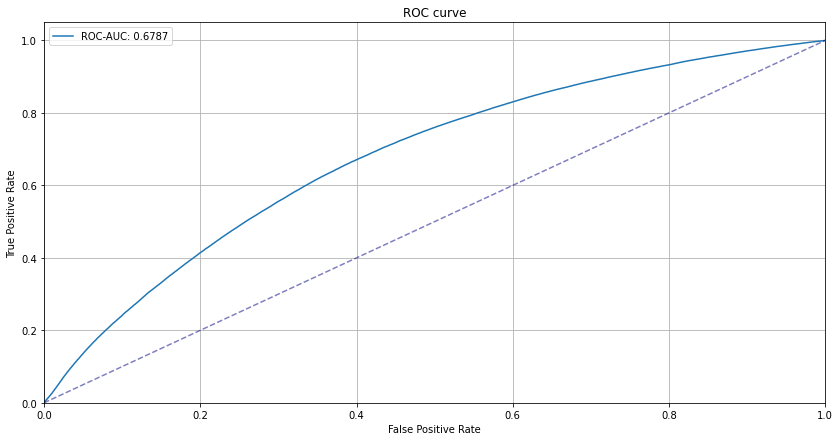

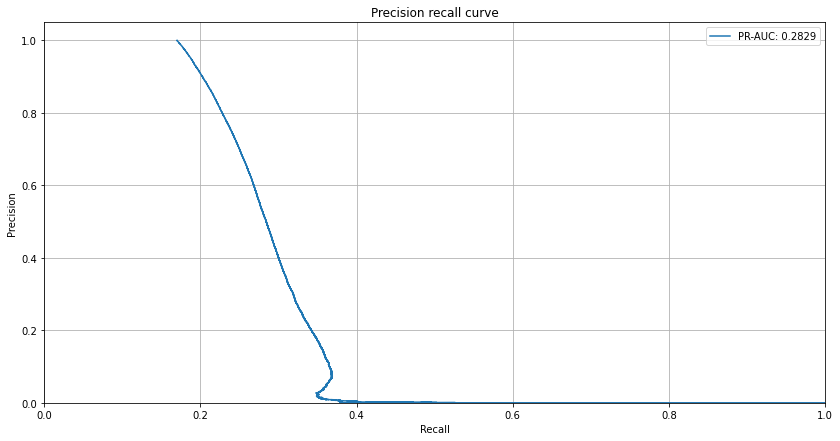

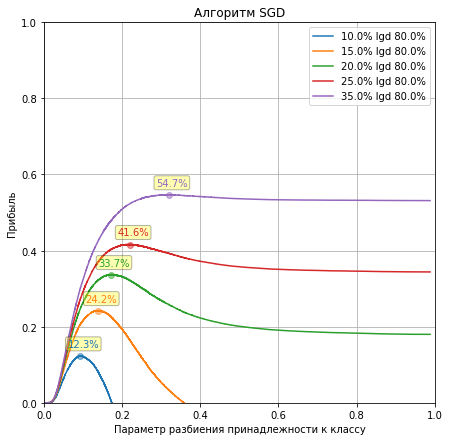

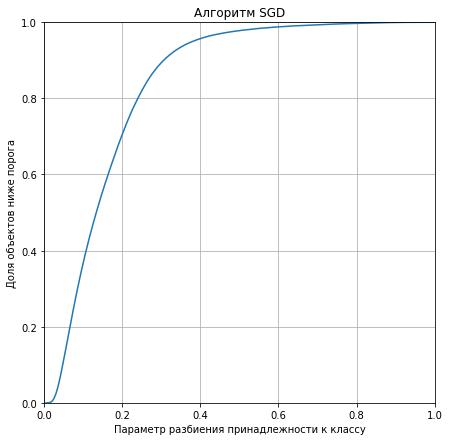

In [0]:
import CreditRisks.metrics_library.profits as metric
plt_roc(y_test,  predict)
plt_pr(y_test,  predict)
metric.plt_profit(y_test.values,  predict, percent_space=[0.10, 0.15, 0.20, 0.25, 0.35], title='Алгоритм SGD')
metric.plt_popularity(predict, title='Алгоритм SGD')

# Модель на Production

In [0]:
lr_prod = LogisticRegression(random_state=42, verbose=1, max_iter=1000).fit(X_prod_1, y_prod)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.1s finished


In [0]:
with open(f'{DIR_OUT}LR_columns_prod.pkl','wb') as f:
    pickle.dump(X_prod_1.columns, f)

In [0]:
with open(f'{DIR_OUT}LR_model_prod.pkl','wb') as f:
    pickle.dump(lr_prod, f)

In [0]:
coefs_prod = pd.DataFrame(abs(lr_prod.coef_.T), index=X_prod_1.columns)
coefs_prod.sort_values(0, ascending=False, inplace=True)
coefs_prod.to_csv(f'{DIR_OUT}Importance_LR_prod.csv')